In [1]:
from copy import copy,deepcopy
from itertools import combinations
import json
import textwrap


from fisher import pvalue_npy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
import requests
import requests_cache


requests_cache.install_cache(
    "pfocr_cache",
    allowable_methods=['GET', 'POST'],
    stale_if_error=False,
)
#requests_cache.remove_expired_responses()

# BTE: Cluster TRAPI Results by Selected PFOCR Figures

From discussion with Andrew, we want to first identify a set of figures that can serve to cluster the TRAPI results. We can call these the "cluster figures". We'll do this by first running Fisher's Exact Test for the CURIEs from each figure vs. all the unique CURIEs found in all the TRAPI results. The subsequent steps are discussed in the TODO NEXT and QUESTIONS at the bottom.

## Get BTE TRAPI Results

In [3]:
query = {
    "message": {
        "query_graph": {
            "edges": {
                "e0": {
                    "subject": "n0",
                    "object": "n1",
                    "predicates": [
                        "biolink:entity_regulates_entity",
                        "biolink:genetically_interacts_with"
                    ]
                },
                "e1": {
                    "subject": "n1",
                    "object": "n2",
                    "predicates": [
                        "biolink:related_to"
                    ]
                }
            },
            "nodes": {
                "n0": {
                    "ids": [
                        "NCBIGene:5872"
                    ],
                    "categories": [
                        "biolink:Gene"
                    ]
                },
                "n1": {
                    "categories": [
                        "biolink:Gene"
                    ],
                },
                "n2": {
                    "categories": [
                        "biolink:SmallMolecule"
                    ]
                }
            }
        }
    }
}

trapi_response = requests.post("http://localhost:3000/v1/query", json=query)
#trapi_response = requests.post("https://api.bte.ncats.io/v1/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/rtxkg2/v1.2/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/arax/v1.2/query", json=query)
print(trapi_response.status_code)
if trapi_response.status_code != 200:
    raise Exception(trapi_response.text)
if trapi_response.from_cache:
    print(f"got response from cache")

trapi_message = trapi_response.json()["message"]

if len(trapi_message["results"]) == 0:
    raise Exception(f'No results returned')

200
got response from cache


Analyze this GraphML file in Cytoscape: ./bte_sleeve_query_template.graphml


{('n0',
  'n1'): Text(0.49997854502503664, 0.008592549969201713, 'biolink:entity_regulates_entity\nbiolink:genetically_interacts_with'),
 ('n1',
  'n2'): Text(-0.49999999999999994, -0.00723722324691318, 'biolink:related_to')}

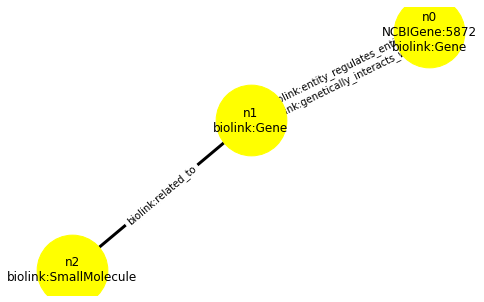

In [4]:
from collections import defaultdict


G = nx.Graph()
query_node_labels = {}
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    node_categories = v.get('categories', [])
    G.add_node(k, categories=', '.join(node_categories))
    query_node_labels[k] = '\n'.join([k] + node_ids + node_categories)
    #G.add_node(k, color='red')

query_edge_labels = {}
q_node_id_keys = set(['object', 'subject'])
for q_edge_id,edge_v in query['message']['query_graph']['edges'].items():
    for predicate in edge_v['predicates']:
        G.add_edge(edge_v['subject'], edge_v['object'], predicate=predicate)
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=', '.join(edge_v['predicates']))
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=[1,2,3])
    #G.add_edge(edge_v['subject'], edge_v['object'])
    query_edge_labels[(edge_v['subject'], edge_v['object'])] = '\n'.join(edge_v['predicates'])
    
query_template_f = './bte_sleeve_query_template.graphml'
print(f'Analyze this GraphML file in Cytoscape: {query_template_f}')
nx.write_graphml(G, query_template_f)

options = {
    'node_color': 'yellow',
    'node_size': 5000,
    'edge_color': 'black',
    'width': 3,
}
query_template_layout = nx.spring_layout(G)
nx.draw(G, pos=query_template_layout, **options)
nx.draw_networkx_labels(G, query_template_layout, labels=query_node_labels, font_size=12,
                        font_color='k', font_family='sans-serif',
                        font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                        verticalalignment='center', ax=None, clip_on=False)
nx.draw_networkx_edge_labels(G, pos=query_template_layout,
                             edge_labels=query_edge_labels,
                             label_pos=0.5, 
                             font_size=10, font_color='k', font_family='sans-serif',
                             font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                             verticalalignment='center', ax=None, rotate=True, clip_on=True)

In [5]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

curie_categories = set()
for v in query["message"]["query_graph"]["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [6]:
# for genes/gene products, chemicals and diseases
preferred_prefixes = set(["NCBIGene", "MESH"])
trapi_results_unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_categories = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    categories = v["categories"]
    curie_categories |= set(categories)

    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]

            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")

            unified_curie = None
            intersecting_trapi_results_unified_curies = trapi_results_unified_curies.intersection(set(curies))
            if len(intersecting_trapi_results_unified_curies) > 1:
                raise Exception(f"matching multiple: {k} to {list(intersecting_trapi_results_unified_curies)}")
            elif len(intersecting_trapi_results_unified_curies) == 1:
                unified_curie = list(intersecting_trapi_results_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        trapi_results_unified_curies.add(unified_curie)
                        break

            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break

                #raise Exception(f"failed to find a unified curie for {k} in {curies}")

            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)

            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                    curie_to_categories[curie] = categories
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")
                    #raise Exception(f"curie{curie} has multiple names: {curie_to_name[curie]} and {name}")


#print(f'curie_categories: {curie_categories}')
#print("")
#print(f"curie_to_name key count: {len(curie_to_name.keys())}")
#print(f"curie_to_unified_curie key count: {len(curie_to_unified_curie.keys())}")
#print("")
print("all CURIE prefixes found:")
print(all_prefixes)
print("")
print("unified CURIE prefixes found:")
print(unified_prefixes)
print("")
print(f"failed to unify {len(unification_failed_curies)} CURIEs")

curie UMLS:C0903898 has multiple primary names: NATEGLINIDE and nateglinide
curie UMLS:C0021641 has multiple primary names: Iletin and Insulin
all CURIE prefixes found:
{'OMIM', 'HGNC', 'INCHIKEY', 'UniProtKB', 'CHEMBL.COMPOUND', 'HMDB', 'GTOPDB', 'PR', 'DRUGBANK', 'MESH', 'NCBIGene', 'PUBCHEM.COMPOUND', 'KEGG.COMPOUND', 'CHEBI', 'DrugCentral', 'UMLS', 'UNII', 'CAS', 'ENSEMBL'}

unified CURIE prefixes found:
{'MESH', 'NCBIGene'}

failed to unify 886 CURIEs


In [7]:
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["message"]["query_graph"]["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)

query_nodes_with_ids = set()
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        query_nodes_with_ids.add(k)

for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_curie")
    columns.append(f"{q_node_id}_unified_curie")

columns.append("trapi_result_curie_combo")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

unified_curie_columns = []
for q_node_id in q_node_ids:
    unified_curie_columns.append(f"{q_node_id}_unified_curie")

In [8]:
trapi_results = trapi_message["results"]

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)

    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curies = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")

            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curies.add(unified_curie)
                    row_data_template[qnode_id + "_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie

    if len(trapi_result_curies) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue

    row_data_template["trapi_result_curie_combo"] = tuple(sorted(trapi_result_curies))
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas

print("warning: predicate direction(s) may be switched")
results_df = pd.DataFrame.from_records(result_row_data, columns=columns).drop_duplicates()
results_df

,n0,e0,n1,e1,n2,n0_curie,n0_unified_curie,n1_curie,n1_unified_curie,n2_curie,n2_unified_curie,trapi_result_curie_combo
0,RAB13,entity_positively_regulates_entity,RAB18,entity_negatively_regulated_by_entity,WATER,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,CHEMBL.COMPOUND:CHEMBL1098659,MESH:D014867,"(MESH:D014867, NCBIGene:22931, NCBIGene:5872)"
1,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,WATER,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,CHEMBL.COMPOUND:CHEMBL1098659,MESH:D014867,"(MESH:D014867, NCBIGene:22931, NCBIGene:5872)"
2,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Isopropyl-beta-D-thiogalactopyranoside,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:656894,MESH:D007544,"(MESH:D007544, NCBIGene:22931, NCBIGene:5872)"
3,RAB13,entity_positively_regulates_entity,RAB18,entity_positively_regulated_by_entity,Trichostatin A,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:444732,MESH:C012589,"(MESH:C012589, NCBIGene:22931, NCBIGene:5872)"
4,RAB13,entity_positively_regulates_entity,RAB18,entity_negatively_regulated_by_entity,Mannitol,NCBIGene:5872,NCBIGene:5872,NCBIGene:22931,NCBIGene:22931,PUBCHEM.COMPOUND:6251,MESH:D008353,"(MESH:D008353, NCBIGene:22931, NCBIGene:5872)"
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,RAB13,genetically_interacts_with,TGFBR1,coexists_with,5' Flanking Region,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,UMLS:C0949645,MESH:D024506,"(MESH:D024506, NCBIGene:5872, NCBIGene:7046)"
6126,RAB13,genetically_interacts_with,TGFBR1,coexists_with,"1,3,4,6-Tetra-O-acetyl-2-azido-2-deoxy-beta-D-...",NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:133445,MESH:C070423,"(MESH:C070423, NCBIGene:5872, NCBIGene:7046)"
6127,RAB13,genetically_interacts_with,TGFBR1,increases_response_to,Thioacetamide,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:2723949,MESH:D013853,"(MESH:D013853, NCBIGene:5872, NCBIGene:7046)"
6128,RAB13,genetically_interacts_with,TGFBR1,affects_response_to,Thioacetamide,NCBIGene:5872,NCBIGene:5872,NCBIGene:7046,NCBIGene:7046,PUBCHEM.COMPOUND:2723949,MESH:D013853,"(MESH:D013853, NCBIGene:5872, NCBIGene:7046)"


Unique CURIE count per query node:

In [9]:
for q_node_id in q_node_ids:
    print(f'{q_node_id}: {len(set(results_df[q_node_id]))}')

n0: 1
n1: 12
n2: 1347


Total results count (excluding any that couldn't be unified):

In [10]:
len(set(results_df["trapi_result_curie_combo"]))

3158

That's too too high for a researcher to efficiently go through manually. Let's try filtering to make that more manageable.

## Get PFOCR Data

We could get it from the API, but for now, we'll just go ahead and download the entire JSON file we gave to BTE.

In [11]:
pfocr_url = "https://www.dropbox.com/s/1f14t5zaseocyg6/bte_chemicals_diseases_genes.ndjson?dl=1"
pfocr_request = requests.get(pfocr_url)
print(f"status_code: {pfocr_request.status_code}")
if pfocr_request.status_code != 200:
    print(pfocr_request.text)

status_code: 200


In [12]:
figures_df_data = []
curies_to_figure_ids = {}
figure_id_to_curies = {}
figure_id_to_pfocr_result = {}
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        if curie in curie_to_unified_curie:
            unified_curie = curie_to_unified_curie[curie]
            curies.add(unified_curie)
        else:
            #print(f"{curie} not in list")
            # this curie isn't in the BTE results, but we'll add an item for
            # the purpose of the denominator in jaccard/containment cals
            curies.add(curie)

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    curies_key = tuple(sorted(curies))
    
    figures_df_data.append({
        "figure_id": figure_id,
        "curie_combo": curies_key,
    })
    
    if curies_key not in curies_to_figure_ids:
        curies_to_figure_ids[curies_key] = []
    curies_to_figure_ids[curies_key].append(figure_id)

figures_df = pd.DataFrame.from_records(figures_df_data)
figures_df

,figure_id,curie_combo
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,"(NCBIGene:10131, NCBIGene:1051, NCBIGene:10563..."
1,PMC5793760__cshperspect-TGF-022210_F4.jpg,"(NCBIGene:151449, NCBIGene:2657, NCBIGene:2658..."
2,PMC5793761__cshperspect-TGF-031989_F1.jpg,"(NCBIGene:1432, NCBIGene:151449, NCBIGene:1686..."
3,PMC5830892__cshperspect-CEL-027961_F2.jpg,"(NCBIGene:2119, NCBIGene:55249, NCBIGene:58, N..."
4,PMC5830900__cshperspect-TGF-031997_F1.jpg,"(MESH:D011374, NCBIGene:151449, NCBIGene:2657,..."
...,...,...
77714,PMC2804790__253_2009_2262_Fig1_HTML.jpg,"(MESH:C018475, MESH:C031105, MESH:C043801, MES..."
77715,PMC6332787__thnov09p0126g006.jpg,"(NCBIGene:29126, NCBIGene:5133, NCBIGene:6387,..."
77716,PMC5807036__IJO-52-03-0787-g01.jpg,"(NCBIGene:1977, NCBIGene:22937, NCBIGene:2313,..."
77717,PMC6770832__cancers-11-01236-g005.jpg,"(NCBIGene:1432, NCBIGene:4086, NCBIGene:4087, ..."


## Fisher Exact Test -- all BTE TRAPI CURIES

The code below identifies the first cluster figure by running Fisher's Exact Test for the CURIEs from each figure vs. all the unique CURIEs found in all the TRAPI results and selecting the figure with the lowest p-value. The subsequent steps are discussed in the TODO NEXT and QUESTIONS at the bottom.

In [13]:
all_genes = set()
gene_instance_count = 0
all_chemicals = set()
chemical_instance_count = 0
all_diseases = set()
disease_instance_count = 0
for figure_id, pfocr_result in figure_id_to_pfocr_result.items():
    genes = pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]
    for gene in genes:
        gene_instance_count += 1
        all_genes.add("NCBIGene:" + gene)

    chemicals = pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]
    for chemical in chemicals:
        chemical_instance_count += 1
        all_chemicals.add("MESH:" + chemical)

    diseases = pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]
    for disease in diseases:
        disease_instance_count += 1
        all_diseases.add("MESH:" + disease)

#print("total instance counts:")
#print(f'  chemicals: {chemical_instance_count}')
#print(f'  diseases: {disease_instance_count}')
#print(f'  genes: {gene_instance_count}')

#print("")

#print("unique counts:")
#print(f'  chemicals: {len(all_chemicals)}')
#print(f'  diseases: {len(all_diseases)}')
#print(f'  genes: {len(all_genes)}')

#print("")

biolink_category_to_pfocr_category = {
    "biolink:ChemicalEntity": "chemicals",
    "biolink:SmallMolecule": "chemicals",
    "biolink:Disease": "diseases",
    "biolink:Gene": "genes",
}

curie_category_to_curies = {
    "biolink:ChemicalEntity": all_chemicals,
    "biolink:SmallMolecule": all_chemicals,
    "biolink:Disease": all_diseases,
    "biolink:Gene": all_genes,
}

# limit to categories returned from query
relevant_categories = set(curie_category_to_curies.keys()).intersection(curie_categories)
all_figure_curies = set()
for curie_category in relevant_categories:
    all_figure_curies |= curie_category_to_curies[curie_category]
all_figure_curie_count = len(all_figure_curies)

print(f'''
Count for all unique CURIEs seen in all figures: {all_figure_curie_count}
Limited to categories matching those from query: {", ".join(relevant_categories)}.
''')


Count for all unique CURIEs seen in all figures: 28735
Limited to categories matching those from query: biolink:ChemicalEntity, biolink:Gene, biolink:SmallMolecule.



In [14]:
len(trapi_results_unified_curies)

1362

In [15]:
curies_in_sample_figure = figures_df[figures_df["figure_id"] == "PMC6361031__13205_2019_1598_Fig1_HTML.jpg"]["curie_combo"].tolist()[0]
print(curies_in_sample_figure)
print(len(curies_in_sample_figure))

('MESH:C010667', 'MESH:C018475', 'MESH:C041787', 'MESH:C043941', 'MESH:C065987', 'MESH:D000079', 'MESH:D000085', 'MESH:D000090', 'MESH:D000096', 'MESH:D000105', 'MESH:D000431', 'MESH:D000440', 'MESH:D002087', 'MESH:D009243')
14


In [16]:
sample_intersection = trapi_results_unified_curies.intersection(set(curies_in_sample_figure))
print(sample_intersection)
print(len(sample_intersection))

{'MESH:D000431', 'MESH:D000079', 'MESH:D009243', 'MESH:D000085', 'MESH:C043941'}
5


For figure PMC6361031__13205_2019_1598_Fig1_HTML.jpg for the all TRAPI CURIEs case,
with the following sources for numbers:

- 28735 is the total number of unique CURIEs found in PFOCR for the categories that correspond to those coming from the query. In this case, that includes chemicals and genes, but not diseases, because the query didn't return any diseases.
- 1362 is the total number of unique CURIEs from all the TRAPI results for our query, with the constraint to only include CURIEs that can be mapped to `NCBIGene` or `MESH`.
- 14 CURIEs in the PFOCR pathway figure, 5 of which are also found in the TRAPI results

|                      | IN THIS FIG | NOT IN THIS FIG  | Total        |
|----------------------|-------------|------------------|--------------|
| IN TRAPI RESULTS     | 5           | 1362 - 5         | 1362         |
| NOT IN TRAPI RESULTS | 9           | 28735 - 1362 - 9 | 28735 - 1362 |
| Total                | 14          | 28735 - 14       | 28735        |

In [17]:
figures_df["figure_curie_count"] = figures_df["curie_combo"].map(len)

figures_df["figure_curies_in_trapi_results"] = figures_df["curie_combo"].map(
    lambda curie_combo: trapi_results_unified_curies.intersection(
        set(curie_combo)
    )
)


# number of CURIEs in both TRAPI results and figure
figures_df["yes_trapi_results_yes_figure"] = figures_df["figure_curies_in_trapi_results"].map(len)

# number of CURIEs in TRAPI results but not in figure
figures_df["yes_trapi_results_no_figure"] = (
    len(trapi_results_unified_curies) -
    figures_df["yes_trapi_results_yes_figure"]
)

# number of CURIEs not in TRAPI results but in figure
figures_df["no_trapi_results_yes_figure"] = (
    figures_df["figure_curie_count"] -
    figures_df["yes_trapi_results_yes_figure"]
)

# number of CURIEs not in TRAPI results and not in figure
figures_df["no_trapi_results_no_figure"] = (
    all_figure_curie_count -
    len(trapi_results_unified_curies) -
    figures_df["no_trapi_results_yes_figure"]
)
figures_df

,figure_id,curie_combo,figure_curie_count,figure_curies_in_trapi_results,yes_trapi_results_yes_figure,yes_trapi_results_no_figure,no_trapi_results_yes_figure,no_trapi_results_no_figure
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,"(NCBIGene:10131, NCBIGene:1051, NCBIGene:10563...",43,{},0,1362,43,27330
1,PMC5793760__cshperspect-TGF-022210_F4.jpg,"(NCBIGene:151449, NCBIGene:2657, NCBIGene:2658...",32,"{NCBIGene:4088, NCBIGene:4089, NCBIGene:7046}",3,1359,29,27344
2,PMC5793761__cshperspect-TGF-031989_F1.jpg,"(NCBIGene:1432, NCBIGene:151449, NCBIGene:1686...",46,"{NCBIGene:64750, NCBIGene:4089}",2,1360,44,27329
3,PMC5830892__cshperspect-CEL-027961_F2.jpg,"(NCBIGene:2119, NCBIGene:55249, NCBIGene:58, N...",8,{},0,1362,8,27365
4,PMC5830900__cshperspect-TGF-031997_F1.jpg,"(MESH:D011374, NCBIGene:151449, NCBIGene:2657,...",37,"{NCBIGene:4088, NCBIGene:4089, MESH:D011374}",3,1359,34,27339
...,...,...,...,...,...,...,...,...
77714,PMC2804790__253_2009_2262_Fig1_HTML.jpg,"(MESH:C018475, MESH:C031105, MESH:C043801, MES...",18,{MESH:D009243},1,1361,17,27356
77715,PMC6332787__thnov09p0126g006.jpg,"(NCBIGene:29126, NCBIGene:5133, NCBIGene:6387,...",4,{},0,1362,4,27369
77716,PMC5807036__IJO-52-03-0787-g01.jpg,"(NCBIGene:1977, NCBIGene:22937, NCBIGene:2313,...",15,{},0,1362,15,27358
77717,PMC6770832__cancers-11-01236-g005.jpg,"(NCBIGene:1432, NCBIGene:4086, NCBIGene:4087, ...",17,"{NCBIGene:4088, NCBIGene:4089, NCBIGene:7046}",3,1359,14,27359


In [18]:
# see https://stackoverflow.com/a/58661068/5354298

_, _, twosided = pvalue_npy(
    figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
    figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
    figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
    figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
)
# TODO: do we need the odds ratio?
#odds = (
#    figures_df["yes_trapi_results_yes_figure"].to_numpy('uint') *
#    figures_df["no_trapi_results_no_figure"].to_numpy('uint')
#) / (
#    figures_df["yes_trapi_results_no_figure"].to_numpy('uint') *
#    figures_df["no_trapi_results_yes_figure"].to_numpy('uint')
#)

figures_df["p_value"] = pd.Series(twosided, index=figures_df.index)
figures_df["p_value"].sort_values()

17099    5.601158e-08
17461    5.601158e-08
51396    5.601158e-08
54833    5.804763e-08
60679    5.804763e-08
             ...     
46540    1.000000e+00
58755    1.000000e+00
3512     1.000000e+00
67356    1.000000e+00
70025    1.000000e+00
Name: p_value, Length: 77719, dtype: float64

(array([14557.,  5886.,  5699.,  2819.,  5719.,  2090.,  6270.,  1377.,
           81., 33221.]),
 array([5.60115811e-08, 1.00000050e-01, 2.00000045e-01, 3.00000039e-01,
        4.00000034e-01, 5.00000028e-01, 6.00000022e-01, 7.00000017e-01,
        8.00000011e-01, 9.00000006e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

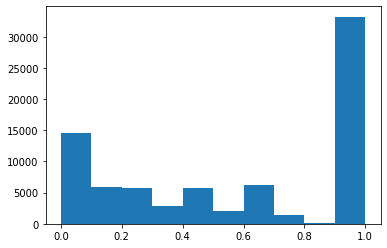

In [19]:
plt.hist(
    figures_df["p_value"]
)

In [20]:
len(figures_df[figures_df["p_value"] < 0.05])

10798

In [21]:
figures_df[figures_df["p_value"] == figures_df["p_value"].min()]

,figure_id,curie_combo,figure_curie_count,figure_curies_in_trapi_results,yes_trapi_results_yes_figure,yes_trapi_results_no_figure,no_trapi_results_yes_figure,no_trapi_results_no_figure,p_value
17099,PMC186586__45793-8f2_F1TT.jpg,"(MESH:C019529, MESH:D000225, MESH:D000641, MES...",10,"{MESH:D000225, MESH:D000641, MESH:D013431, MES...",9,1353,1,27372,5.601158e-08
17461,PMC4913105__fmicb-07-00953-g0001.jpg,"(MESH:C008973, MESH:D000244, MESH:D000255, MES...",10,"{MESH:D000641, MESH:D011700, MESH:D002245, MES...",7,1355,3,27370,5.601158e-08
51396,PMC92149__am0800394004.jpg,"(MESH:C008500, MESH:C008973, MESH:C013863, MES...",10,"{MESH:D011700, MESH:C008500, MESH:D001120, MES...",8,1354,2,27371,5.601158e-08


This is interesting -- the CURIEs in the top figures are very disproportionately chemicals:

In [22]:
for i, row in figures_df.sort_values("p_value").head(10).iterrows():
    chemical_count = 0
    gene_count = 0
    for curie in set(row["curie_combo"]):
        if curie in all_chemicals:
            chemical_count += 1
        if curie in all_genes:
            gene_count += 1
    print(f'  chemicals: {chemical_count}, genes: {gene_count}')

  chemicals: 9, genes: 0
  chemicals: 9, genes: 1
  chemicals: 9, genes: 0
  chemicals: 11, genes: 3
  chemicals: 14, genes: 0
  chemicals: 14, genes: 5
  chemicals: 14, genes: 5
  chemicals: 17, genes: 1
  chemicals: 13, genes: 6
  chemicals: 18, genes: 0


Here's what we get from the bottom results:

In [23]:
for i, row in figures_df.sort_values("p_value").tail(10).iterrows():
    chemical_count = 0
    gene_count = 0
    for curie in set(row["curie_combo"]):
        if curie in all_chemicals:
            chemical_count += 1
        if curie in all_genes:
            gene_count += 1
    print(f'  chemicals: {chemical_count}, genes: {gene_count}')

  chemicals: 1, genes: 0
  chemicals: 1, genes: 1
  chemicals: 0, genes: 11
  chemicals: 8, genes: 3
  chemicals: 0, genes: 1
  chemicals: 0, genes: 11
  chemicals: 1, genes: 24
  chemicals: 2, genes: 9
  chemicals: 0, genes: 2
  chemicals: 1, genes: 0


I chose one of the three figures tied for the lowest p-value:

In [24]:
best_figure_row = figures_df[figures_df["figure_id"] == "PMC186586__45793-8f2_F1TT.jpg"]

In [25]:
best_figure_curies = set(best_figure_row["curie_combo"].tolist()[0])
best_figure_curies

{'MESH:C019529',
 'MESH:D000225',
 'MESH:D000641',
 'MESH:D001120',
 'MESH:D001127',
 'MESH:D002244',
 'MESH:D002245',
 'MESH:D010100',
 'MESH:D010710',
 'MESH:D013431'}

TODO NEXT:
1. Excluding the CURIEs from the best figure, repeat the process to get the second-best figure. Continue until we've excluded all the TRAPI results CURIEs. Now we have a set of figures to use to cluster the TRAPI results. We can call these our "cluster figures".
2. Group each TRAPI result with the cluster figure most relevant to it, based on Fisher's Exact Test, similar to how we did the grouping in the bte_sleeve.ipynb notebook that is a sibling of this notebook. The main difference will be that instead of grouping TRAPI results by all PFOCR figures like in that notebook, we'll instead just group by the selected subset of PFOCR figures we're calling the cluster figures.
3. Display each cluster figure along with the top 10 TRAPI results most relevant to it, similar to the "By figure" section of the bte_sleeve.ipynb notebook.

QUESTIONS:
1. What should we do in cases of ties for p-values for identifying cluster figures? We could treat them like one large figure and display them all.
2. Should we do anything special for cluster figures and TRAPI results that have any of the ids the user specified?